In [3]:
import cv2

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from utils.dataset import ImageSet, transform
from utils.metrics import plot_metrics

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/tomek/.local/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/home/tomek/.local/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='c

# OpenCV Scalling

In [4]:
def classic_upscale(img):
    return cv2.resize(img, [256, 256], interpolation=2) # 2 = bicubic interpolation

# Neural Network Scalling

### Dataset

In [5]:
train_dataset = ImageSet("data/scalling/train", "data/intermediate/train", transform)
valid_dataset = ImageSet("data/scalling/valid", "data/intermediate/valid", transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

### Model

In [6]:
class UpscaleCNN(nn.Module):
    def __init__(self):
        super(UpscaleCNN, self).__init__()

        # Encoder: 32x32 -> feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )

        # Decoder: 4x4 -> 256x256 (upscaling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# model = UpscaleCNN()
# model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

In [ ]:
# import tqdm

# num_epochs = 30

# losses = {"train":[],"val":[]}

# for epoch in range(num_epochs):
#     model.train()
#     for x, y in tqdm.tqdm(train_dataloader):
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad() 
#         out = model(x)
#         loss = criterion(out, y)

#         loss.backward()
#         optimizer.step()
    
#     model.eval()
#     print(f"epoch #{epoch+1}, loss: {loss}")
#     losses["train"].append(loss)
#     with torch.no_grad():
#         total_loss = 0.0
#         for x, y in valid_dataset:
#             x, y = x.to(device), y.to(device)
#             out = model(x)

#             loss = criterion(out, y)

#             total_loss += loss.item()
#         print("Validation loss:",total_loss)
#     losses["val"].append(total_loss)

100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


epoch #1, loss: 0.029000263661146164
Validation loss: 4.067942553199828


100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


epoch #2, loss: 0.049932267516851425
Validation loss: 3.767046146094799


100%|██████████| 100/100 [00:03<00:00, 30.96it/s]


epoch #3, loss: 0.04865690693259239
Validation loss: 3.5614272775128484


100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


epoch #4, loss: 0.032682210206985474
Validation loss: 3.4390965458005667


100%|██████████| 100/100 [00:03<00:00, 30.98it/s]


epoch #5, loss: 0.038973551243543625
Validation loss: 3.221933147870004


100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


epoch #6, loss: 0.029731430113315582
Validation loss: 3.1594334095716476


100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


epoch #7, loss: 0.03766315430402756
Validation loss: 3.0742581854574382


100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


epoch #8, loss: 0.028642354533076286
Validation loss: 3.145156590268016


100%|██████████| 100/100 [00:03<00:00, 30.98it/s]


epoch #9, loss: 0.03370559215545654
Validation loss: 3.0240785386413336


100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


epoch #10, loss: 0.02760525606572628
Validation loss: 3.0020245714113116


100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


epoch #11, loss: 0.04116494208574295
Validation loss: 2.9883335777558386


100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


epoch #12, loss: 0.024784505367279053
Validation loss: 2.948318086564541


100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


epoch #13, loss: 0.028724640607833862
Validation loss: 3.0200455794110894


100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


epoch #14, loss: 0.03106088563799858
Validation loss: 2.9084630319848657


100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


epoch #15, loss: 0.023913737386465073
Validation loss: 2.9003698066808283


100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


epoch #16, loss: 0.03283165767788887
Validation loss: 2.889394863974303


100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


epoch #17, loss: 0.03127790987491608
Validation loss: 2.8785532196052372


100%|██████████| 100/100 [00:03<00:00, 31.02it/s]


epoch #18, loss: 0.036161474883556366
Validation loss: 2.8451442238874733


100%|██████████| 100/100 [00:03<00:00, 30.96it/s]


epoch #19, loss: 0.03206702321767807
Validation loss: 2.8585460437461734


100%|██████████| 100/100 [00:03<00:00, 31.03it/s]


epoch #20, loss: 0.02522488310933113
Validation loss: 2.8224721448495984


100%|██████████| 100/100 [00:03<00:00, 30.96it/s]


epoch #21, loss: 0.02609831653535366
Validation loss: 2.8101036893203855


100%|██████████| 100/100 [00:03<00:00, 31.04it/s]


epoch #22, loss: 0.03275008127093315
Validation loss: 2.601235203910619


100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


epoch #23, loss: 0.025883633643388748
Validation loss: 2.472048581112176


100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


epoch #24, loss: 0.017293427139520645
Validation loss: 2.483319557271898


100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


epoch #25, loss: 0.0219765305519104
Validation loss: 2.3710357579402626


100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


epoch #26, loss: 0.02830418571829796
Validation loss: 2.4444011324085295


100%|██████████| 100/100 [00:03<00:00, 31.06it/s]


epoch #27, loss: 0.02616143599152565
Validation loss: 2.4264317229390144


100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


epoch #28, loss: 0.02532470040023327
Validation loss: 2.343148423358798


100%|██████████| 100/100 [00:03<00:00, 31.08it/s]


epoch #29, loss: 0.027201354503631592
Validation loss: 2.3584763151593506


100%|██████████| 100/100 [00:03<00:00, 31.10it/s]


epoch #30, loss: 0.024203982204198837
Validation loss: 2.3564130342565477


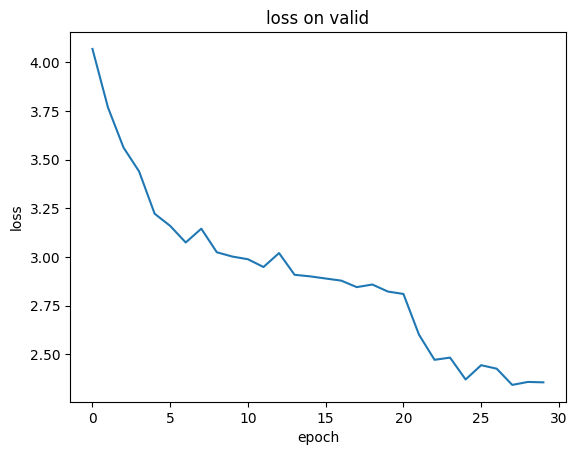

In [ ]:
# x = range(num_epochs)
# y = losses['val']

# plt.plot(x, y)
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("loss on valid")
# plt.show()

In [ ]:
# torch.save(model, "model_scaling.pth")

## Results

In [ ]:
model = torch.load('model_scaling.pth')
model.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08677552..1.1345453].


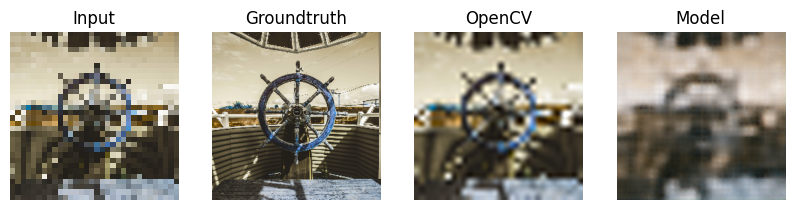

In [13]:
a = random.choice(valid_dataset)

model.eval()

input = a[0].permute(1, 2, 0).detach().numpy()

out = model(a[0].to(device))
out = out.permute(1, 2, 0).detach().cpu().numpy()

dest = a[1].permute(1, 2, 0).detach().numpy()

fig, axes = plt.subplots(1, 4, figsize=(10, 5)) 

axes[0].imshow(input)
axes[0].axis('off')
axes[0].set_title("Input")

axes[1].imshow(dest)
axes[1].axis('off')
axes[1].set_title("Groundtruth")

axes[2].imshow(classic_upscale(input))
axes[2].axis('off')
axes[2].set_title("OpenCV")

axes[3].imshow(out)
axes[3].axis('off')
axes[3].set_title("Model")

plt.show()

### Metrics

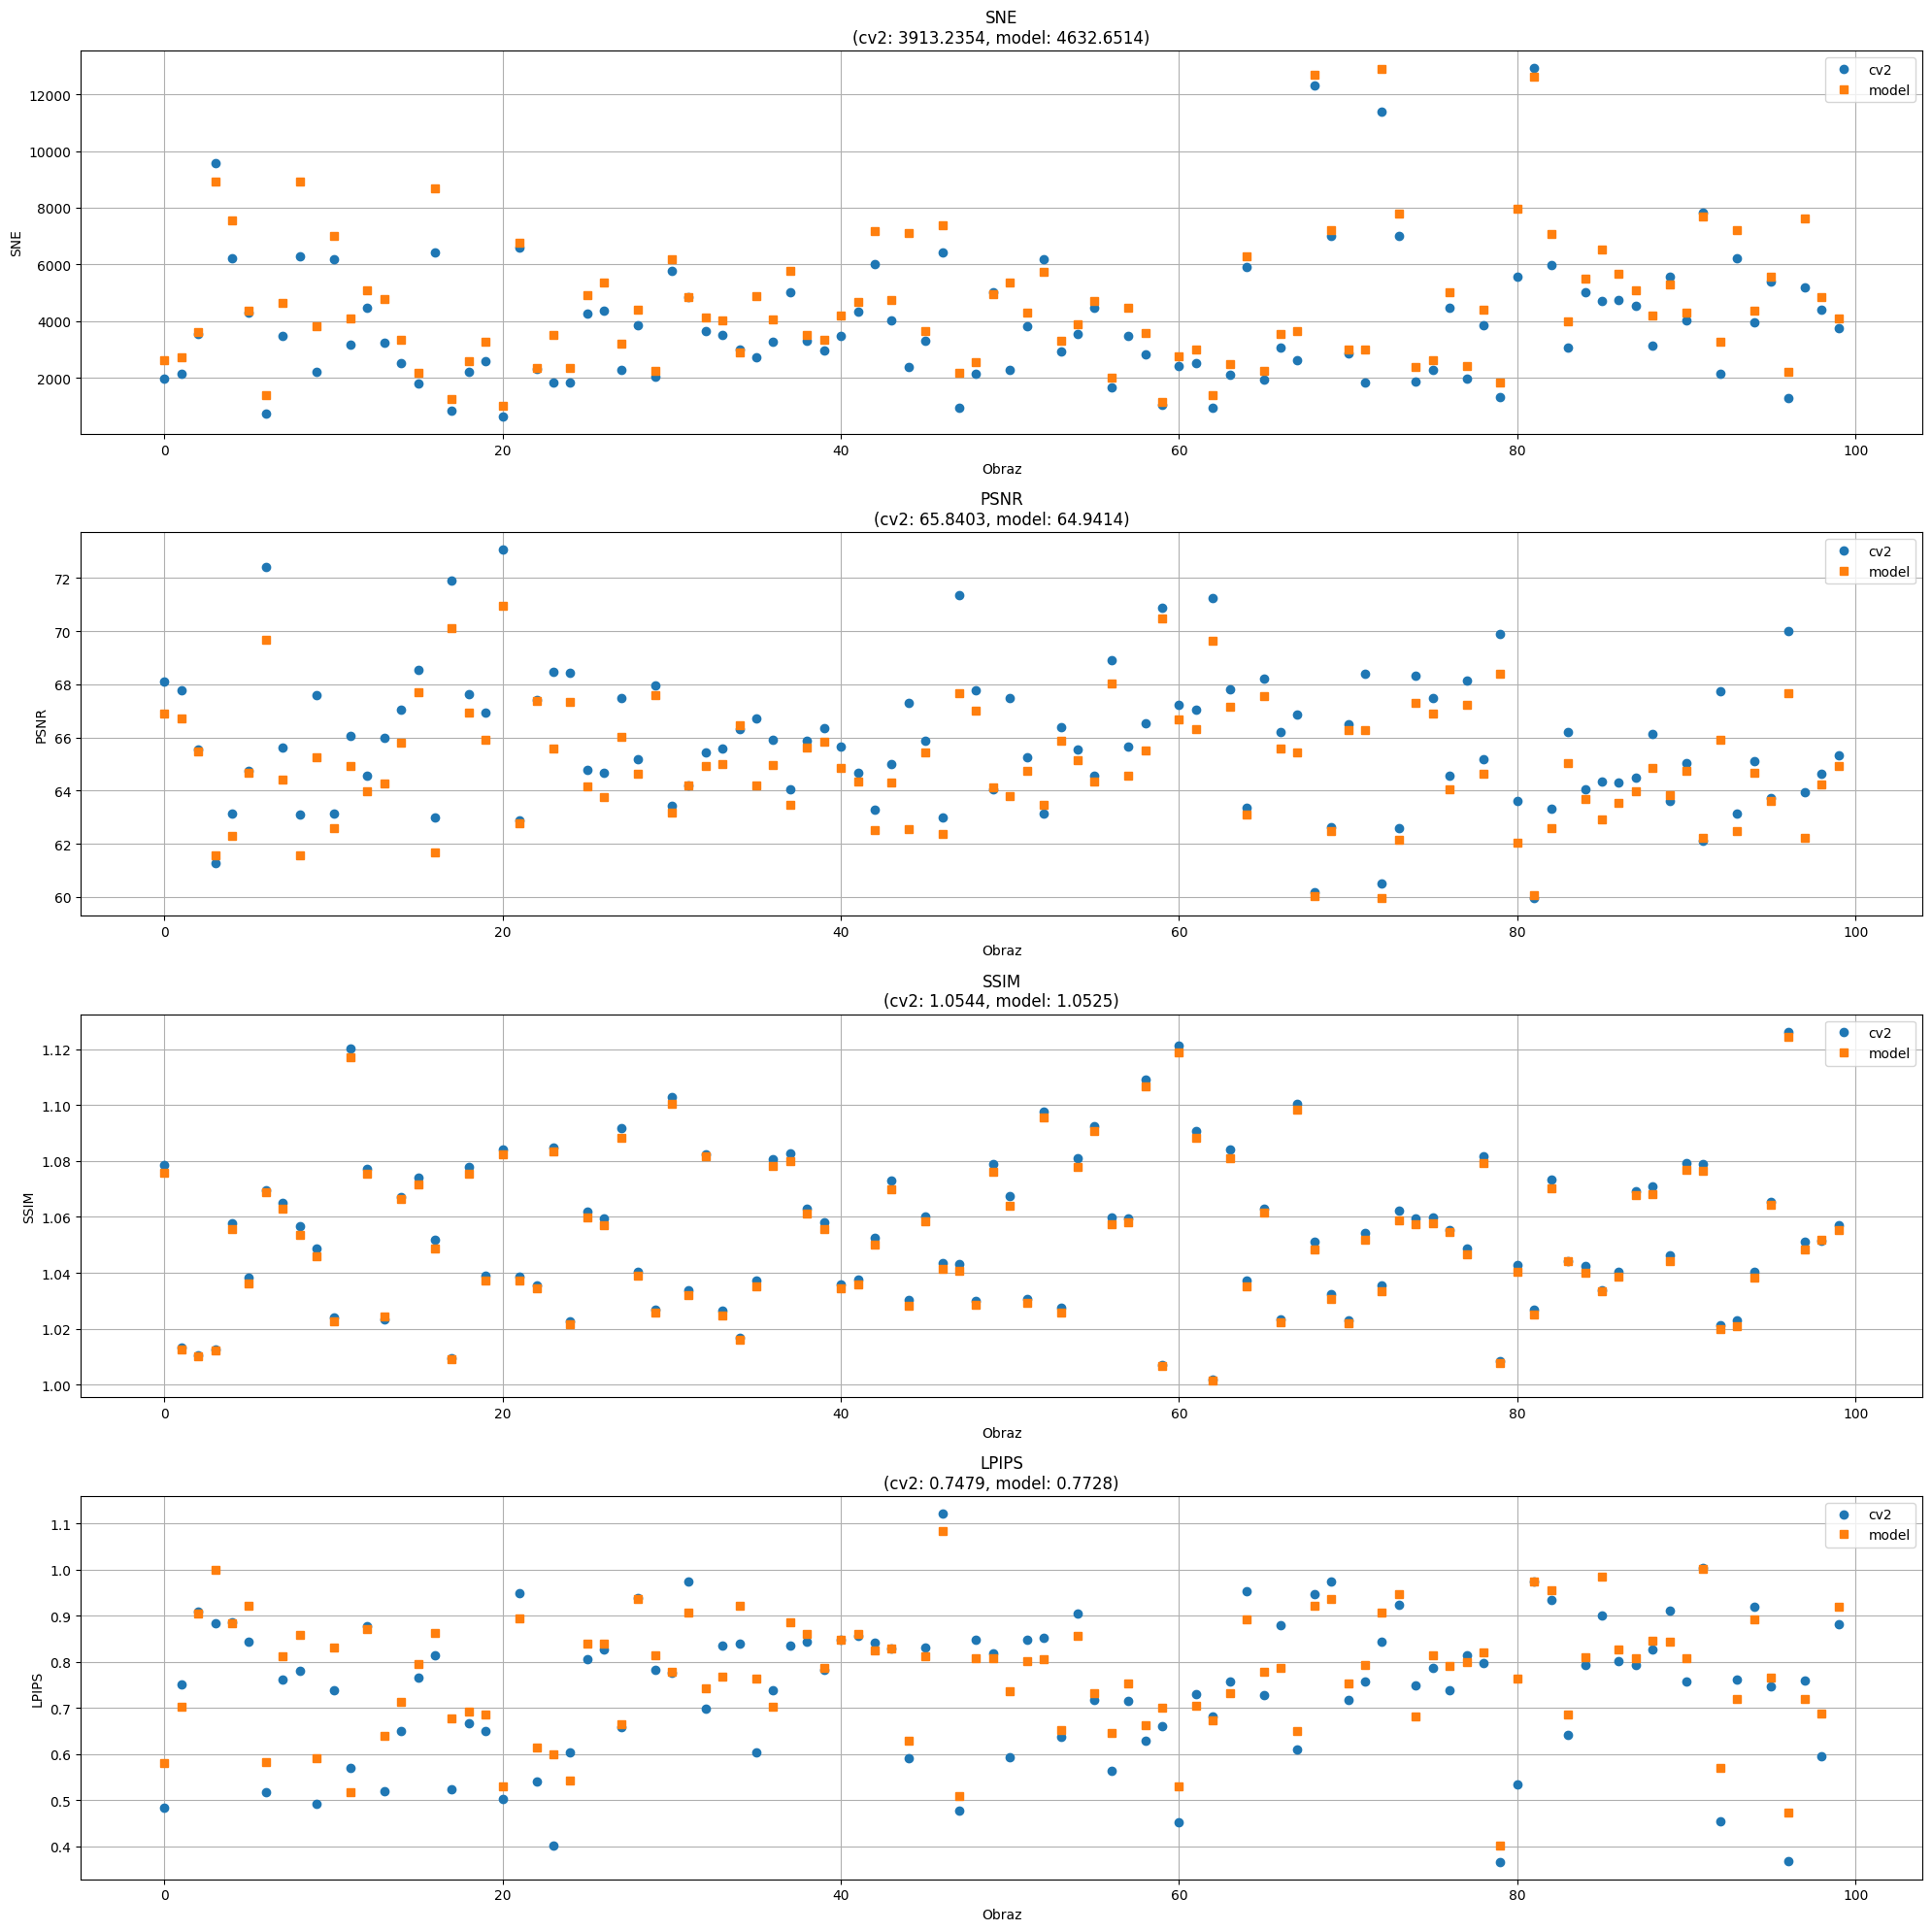

In [14]:
ground_truth_list = []
cv2_list = []
model_list = []

model.eval()

for x, y in valid_dataset:
    ground_truth_list.append(y.permute(1, 2, 0).detach().numpy())

    cv2_list.append(classic_upscale(x.permute(1, 2, 0).detach().numpy()))

    model_list.append(model(x.to(device)).permute(1, 2, 0).detach().cpu().numpy())


plot_metrics(ground_truth_list, cv2_list, model_list)